In [1]:
# docs and experiment results can be found at https://docs.cleanrl.dev/rl-algorithms/ddpg/#ddpg_continuous_actionpy
import random

import gymnasium as gym
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim

import json
import bridgestan as bs
from posteriordb import PosteriorDatabase

from stable_baselines3.common.buffers import ReplayBuffer

import sys
sys.path.append('../..')
from tqdm.auto import trange

from src.rlmcmc.agent import Actor, QNetwork
from src.rlmcmc.env import RLMHEnvV31
from src.rlmcmc.utils import Args, Toolbox

In [2]:
# Load DataBase Locally
my_pdb = PosteriorDatabase("../../posteriordb/posterior_database")

# Load Dataset
posterior = my_pdb.posterior("test-SimpleEggBox-test-SimpleEggBox")
stan_code = posterior.model.stan_code_file_path()
# stan_data = json.dumps(posterior.data.values())
stan_data = json.dumps({"sigma": 1, "r": 20})
model = bs.StanModel.from_stan_file(stan_code, stan_data)

# Extract log_target_pdf
log_p = model.log_density

In [3]:
# env setup
args = Args()
args.seed = 1234
args.log_target_pdf = log_p
args.total_timesteps = 100_000
args.batch_size = 32
args.learning_starts = args.batch_size
# args.learning_starts = 5_000
args.gamma = 0.99
# args.buffer_size = args.total_timesteps
args.learning_rate = 1e-5
args.policy_frequency = 2

# TRY NOT TO MODIFY: seeding
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

# env setup
envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=args.log_target_pdf,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)
assert isinstance(envs.single_action_space, gym.spaces.Box), "only continuous action space is supported"

actor = Actor(envs).to(device)
actor = actor.double()
qf1 = QNetwork(envs).to(device)
qf1 = qf1.double()
qf2 = QNetwork(envs).to(device)
qf2 = qf2.double()
qf1_target = QNetwork(envs).to(device)
qf1_target = qf1_target.double()
qf2_target = QNetwork(envs).to(device)
qf2_target = qf2_target.double()
target_actor = Actor(envs).to(device)
target_actor = target_actor.double()
target_actor.load_state_dict(actor.state_dict())
qf1_target.load_state_dict(qf1.state_dict())
qf2_target.load_state_dict(qf2.state_dict())
q_optimizer = optim.Adam(list(qf1.parameters()) + list(qf2.parameters()), lr=args.learning_rate)
actor_optimizer = optim.Adam(list(actor.parameters()), lr=args.learning_rate)

envs.single_observation_space.dtype = np.float64
rb = ReplayBuffer(
    args.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False,
)

In [4]:
obs, _ = envs.reset(seed=args.seed)

In [5]:
for global_step in trange(args.total_timesteps):
    # ALGO LOGIC: put action logic here
    if global_step < args.learning_starts:
        actions = np.array(
            [
                np.hstack(
                    (
                        np.eye(args.sample_dim, dtype=np.float64).reshape(-1, args.sample_dim << 1),
                        np.eye(args.sample_dim, dtype=np.float64).reshape(-1, args.sample_dim << 1)
                    )
                ) for _ in range(envs.num_envs)
            ]
        ).reshape(1, -1)
    else:
        with torch.no_grad():
            actions = actor(torch.from_numpy(obs).to(device))

    next_obs, rewards, terminations, truncations, infos = envs.step(actions)

    real_next_obs = next_obs.copy()
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    obs = next_obs

    # ALGO LOGIC: training.
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        with torch.no_grad():
            # clipped_noise = (torch.randn_like(data.actions, device=device) * args.policy_noise).clamp(
            #     -args.noise_clip, args.noise_clip
            # ) * target_actor.action_scale

            # next_state_actions = (target_actor(data.next_observations) + clipped_noise).clamp(
            #     envs.single_action_space.low[0], envs.single_action_space.high[0]
            # )
            next_state_actions = target_actor(data.next_observations)
            qf1_next_target = qf1_target(data.next_observations, next_state_actions)
            qf2_next_target = qf2_target(data.next_observations, next_state_actions)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target)
            next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * args.gamma * (min_qf_next_target).view(-1)

        qf1_a_values = qf1(data.observations, data.actions).view(-1)
        qf2_a_values = qf2(data.observations, data.actions).view(-1)
        qf1_loss = F.mse_loss(qf1_a_values, next_q_value)
        qf2_loss = F.mse_loss(qf2_a_values, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        # optimize the model
        q_optimizer.zero_grad()
        qf_loss.backward()
        q_optimizer.step()

        if global_step % args.policy_frequency == 0:
            actor_loss = -qf1(data.observations, actor(data.observations)).mean()
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            # update the target network
            for param, target_param in zip(actor.parameters(), target_actor.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
            for param, target_param in zip(qf1.parameters(), qf1_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)
            for param, target_param in zip(qf2.parameters(), qf2_target.parameters()):
                target_param.data.copy_(args.tau * param.data + (1 - args.tau) * target_param.data)


  0%|          | 0/100000 [00:00<?, ?it/s]

In [6]:
env = envs.unwrapped.envs[0].env.env.env
observation_list = np.array([i for i in env.store_observation]).reshape(-1, env.sample_dim << 1)
action_list = np.array([i for i in env.store_action]).reshape(-1, env.sample_dim**2 << 1)

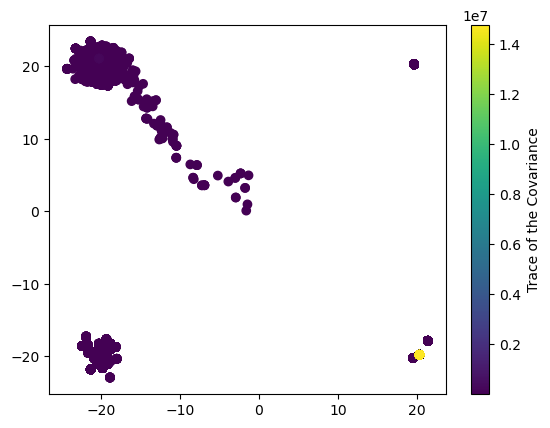

In [7]:
from matplotlib import pyplot as plt


fig, ax = plt.subplots()
sc = ax.scatter(observation_list[1:, 0], observation_list[1:, 1], c=(action_list[:, 0] + action_list[:, 3]), cmap='viridis')

plt.colorbar(sc, label='Trace of the Covariance')
plt.show()


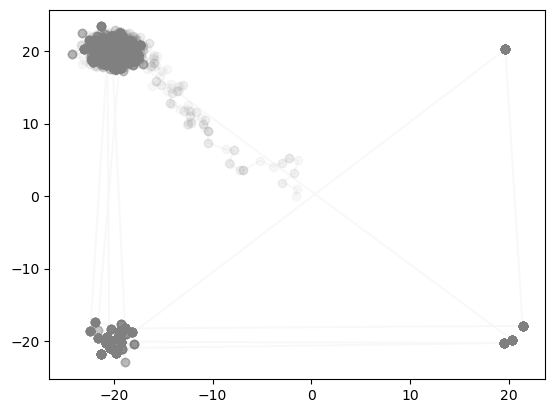

In [8]:
plt.plot(observation_list[1:, 0], observation_list[1:, 1], 'o-', color='grey', alpha=0.05)

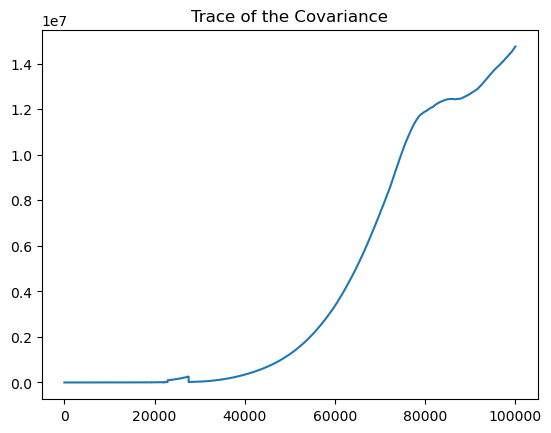

In [9]:
plt.plot(action_list[:, 0] + action_list[:, 3])
plt.title("Trace of the Covariance")
plt.show()

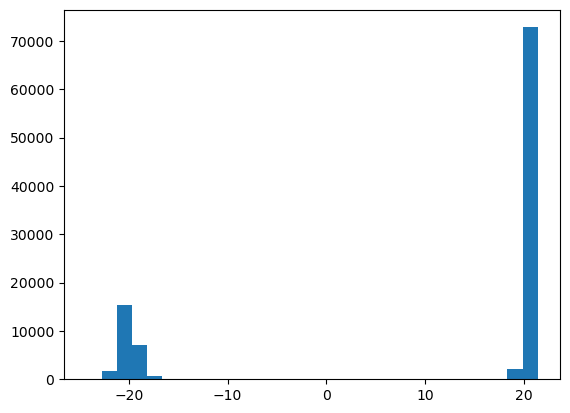

In [10]:
plt.hist(observation_list[:, 0], bins=30)
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


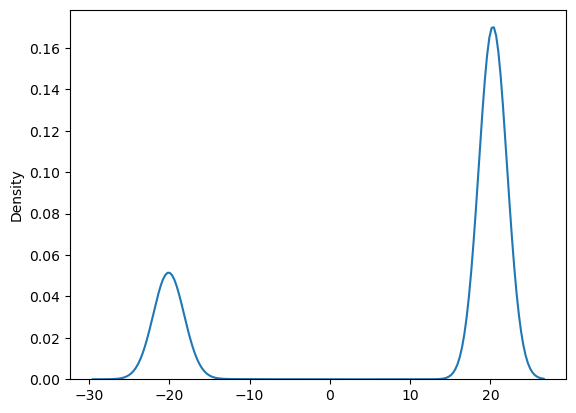

In [11]:
import seaborn as sns

sns.kdeplot(observation_list[:, 0])
plt.show()

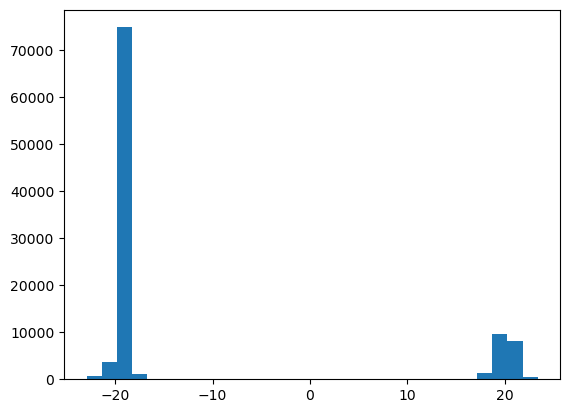

In [12]:
plt.hist(observation_list[:, 1], bins=30)
plt.show()

/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/congye/Software/anaconda3/envs/rl/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


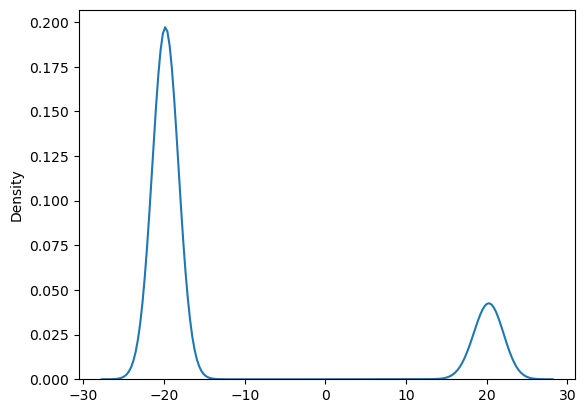

In [13]:
sns.kdeplot(observation_list[:, 1])
plt.show()

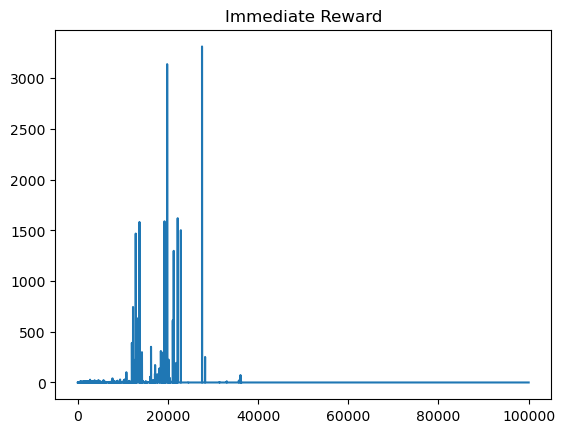

In [14]:
plt.plot(env.store_reward)
plt.title("Immediate Reward")
plt.show()

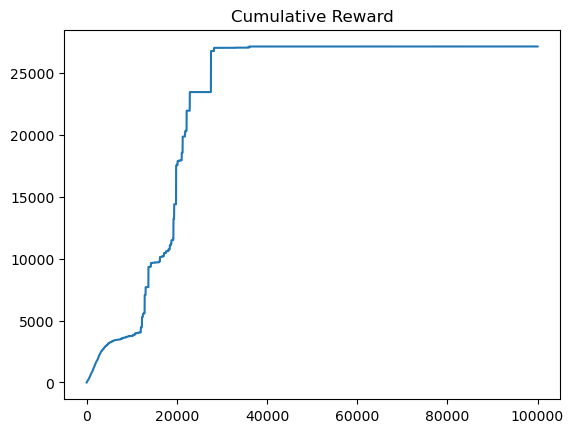

In [15]:
plt.plot(np.cumsum(env.store_reward))
plt.title("Cumulative Reward")
plt.show()

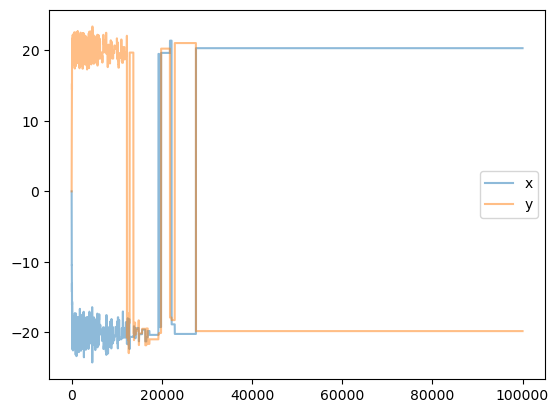

In [16]:
plt.plot(observation_list[:, 0], label="x", alpha=0.5)
plt.plot(observation_list[:, 1], label="y", alpha=0.5)
plt.legend()
plt.show()

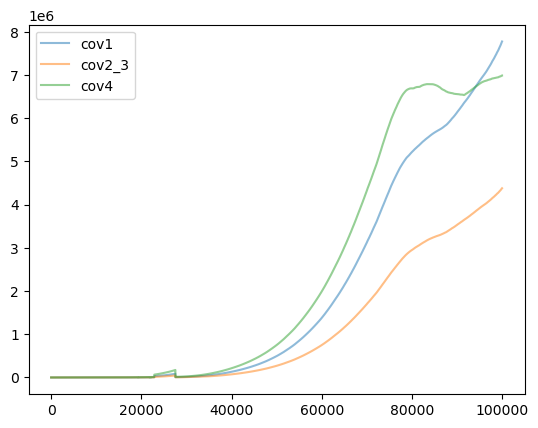

In [17]:
plt.plot(action_list[:, 0], label="cov1", alpha=0.5)
plt.plot(action_list[:, 1], label="cov2_3", alpha=0.5)
plt.plot(action_list[:, 3], label="cov4", alpha=0.5)
plt.legend()
plt.show()

In [18]:
np.sum(env.store_accetped_status)/len(env.store_accetped_status)

0.015669843301566986

In [19]:
import pandas as pd
df = pd.DataFrame(
    np.hstack(
        [
    observation_list[1:, 0:2],
    action_list[:, 0:4],
    np.array(env.store_reward).reshape(-1, 1)[1:],
    np.array(env.store_log_accetance_rate).reshape(-1, 1)[1:],
    np.array(env.store_accetped_status).reshape(-1, 1)[1:]
        ]
    ),
    columns=['x', 'y', 'cov1', 'cov2', 'cov3', 'cov4', 'rewards', 'log_alpha', 'accepted_status']
)
# Find the row with the largest value in the 'rewards' column
max_rewards_row = df.loc[
    [
        df['rewards'].idxmax() - 4,
        df['rewards'].idxmax() - 3,
        df['rewards'].idxmax() - 2,
        df['rewards'].idxmax() - 1,
        df['rewards'].idxmax(),
        df['rewards'].idxmax() + 1,
        df['rewards'].idxmax() + 2,
        df['rewards'].idxmax() + 3,
        df['rewards'].idxmax() + 4
    ]
]

max_rewards_row

,x,y,cov1,cov2,cov3,cov4,rewards,log_alpha,accepted_status
27552,-20.228081,21.044491,86335.809830,45641.108408,45641.108408,173822.133413,0.000000e+00,-3.402823e+38,0.0
27553,-20.228081,21.044491,86370.277361,45660.128732,45660.128732,173884.616252,0.000000e+00,-3.402823e+38,0.0
27554,-20.228081,21.044491,86370.277361,45660.128732,45660.128732,173884.616252,0.000000e+00,-3.402823e+38,0.0
27555,-20.228081,21.044491,86404.560809,45678.993037,45678.993037,173946.741870,0.000000e+00,-3.402823e+38,0.0
27556,20.316899,-19.825139,86404.560809,45678.993037,45678.993037,173946.741870,3.314222e+03,0.000000e+00,1.0
27557,20.316899,-19.825139,7514.185204,4326.629696,4326.629696,14491.494794,0.000000e+00,-3.402823e+38,0.0
27558,20.316899,-19.825139,7514.185204,4326.629696,4326.629696,14491.494794,3.823121e-163,-3.806379e+02,0.0
27559,20.316899,-19.825139,7517.531434,4328.542631,4328.542631,14497.440031,0.000000e+00,-3.402823e+38,0.0
27560,20.316899,-19.825139,7517.531434,4328.542631,4328.542631,14497.440031,0.000000e+00,-3.402823e+38,0.0
